## Forecasting forex using ARIMA for USD/VND 
#### Using data from past two years (2021 and 2022), we'll forecast data for 2023 to forecast for next 12 months (short time period)
The purpose of this research is to forecast usd/vnd exchnage rate to use in our investment analysis.

# Import packages

In [163]:
# Import packages
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
import plotly.io as pio

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_predict

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

from pandas import DataFrame
from matplotlib import pyplot

from pmdarima.arima import auto_arima

from datetime import datetime

## Input data

[*********************100%%**********************]  1 of 1 completed


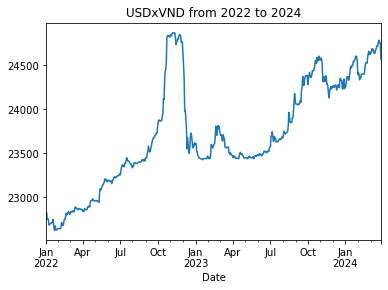

In [179]:
# Get data
data = yf.download('USDVND=X','2022-01-01','2024-12-31') # from 1 Jan 2021 to 31 December 2022

# Plot
data['Adj Close'].plot()
plt.title("USDxVND from 2022 to 2024")
plt.show()

# Seperate into train and test data
df = pd.DataFrame(data['Adj Close']) 
df = df.reset_index()
msk = (df.index < len(df)-365)
df_train = df[msk].copy()
df_test = df[~msk].copy()

## Stationary test

C:\Users\User\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


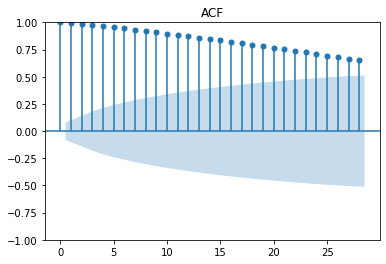

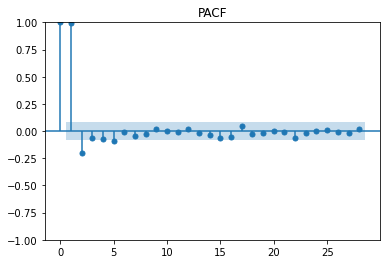

In [180]:
# Autocorrelation and partial correlation function of data
plot_acf(df['Adj Close'])
plt.title("ACF")
plot_pacf(df['Adj Close'])
plt.title("PACF")
plt.show()

In [181]:
adftest = adfuller(df['Adj Close'], autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")


ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -2.63201312090133
P-Value: 0.26537910938120535
Number of lags: 6
Number of observations: 576
Critical Values: {'1%': -3.9745735738208494, '5%': -3.4181396948974774, '10%': -3.1315508362695517}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


##### Differencing 

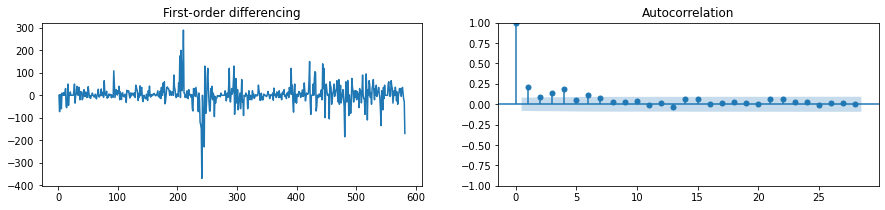

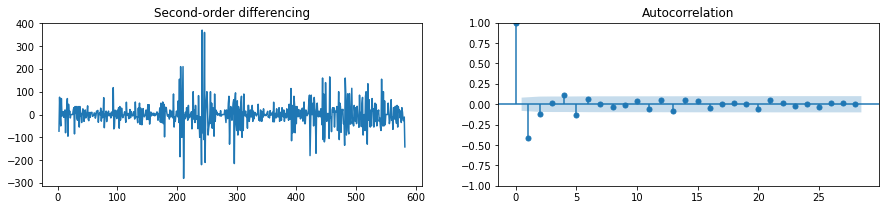

In [182]:
# First-order differencing
df['diff1'] = df['Adj Close'].diff().dropna()
f = plt.figure(figsize=(15,3))
ax1 = f.add_subplot(121)
ax1.set_title('First-order differencing')
ax1.plot(df['diff1'])

df['growth_1'] = df['diff1']*100 # Convert first-order difference to growth rates by mutiplying by 100
ax2 = f.add_subplot(122)
plot_acf(df['diff1'].dropna(), ax=ax2)
plt.show()

# Second order differencing
df['diff2'] = df['Adj Close'].diff().diff().dropna()
f = plt.figure(figsize=(15,3))
ax1 = f.add_subplot(121)
ax1.set_title('Second-order differencing')
ax1.plot(df['diff2'])

df['growth_2'] = df['diff2']*100 # Convert first-order difference to growth rates by mutiplying by 100
ax2 = f.add_subplot(122)
plot_acf(df['diff2'].dropna(), ax=ax2)
plt.show()



In [183]:
# Test stationarity with ADF
adftest = adfuller(df['growth_1'].dropna(), autolag = 'AIC', regression = 'n')
print("ADF Test Results")
print("Null Hypothesis: The series has an Unit Root")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null Hypothesis and the series is Stationary")


ADF Test Results
Null Hypothesis: The series has an Unit Root
ADF-Statistic: -6.936642158517284
P-Value: 8.3943800247479e-11
Number of lags: 5
Number of observations: 576
Critical Values {'1%': -2.5696325292968747, '5%': -1.9414762984465508, '10%': -1.6163669363826128}
Note: If P-Value is smaller than 0.05, we reject the null Hypothesis and the series is Stationary


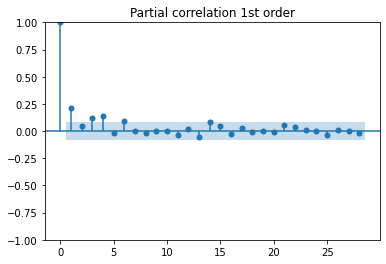

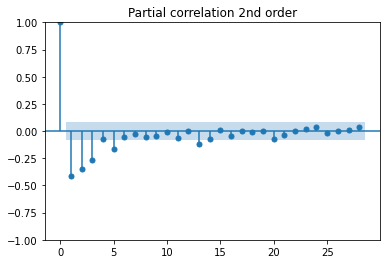

In [184]:
# Partial autocorrelation
plot_pacf(df['diff1'].dropna(),method='ywm')
plt.title('Partial correlation 1st order')
plt.show()

plot_pacf(df['diff2'].dropna(),method='ywm')
plt.title('Partial correlation 2nd order')
plt.show()

# ARIMA model parameters

In [185]:
# Finding ARIMA parameters automatically
model = auto_arima(df_train['Adj Close'], seasonal=False, stepwise= False, d= None, suppress_warnings=True)
print(model.order)

(0, 2, 1)


# Fitting ARIMA

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  218
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1080.246
Date:                Wed, 27 Mar 2024   AIC                           2164.491
Time:                        13:09:02   BIC                           2171.251
Sample:                             0   HQIC                          2167.222
                                - 218                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2416      0.043      5.684      0.000       0.158       0.325
sigma2      1233.5579     39.581     31.165      0.000    1155.980    1311.136
Ljung-Box (L1) (Q):                   1.71   Jarque-

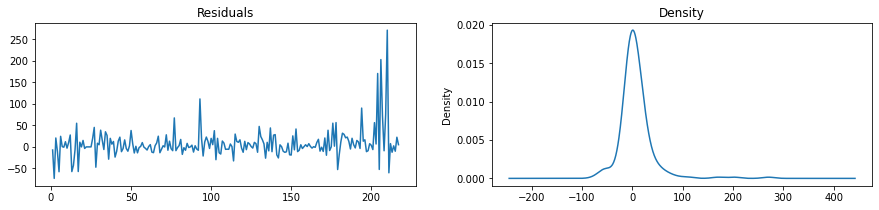

count    217.000000
mean       7.054937
std       34.492583
min      -73.000000
25%       -7.765346
50%        1.416195
75%       15.000000
max      270.670439
dtype: float64


C:\Users\User\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


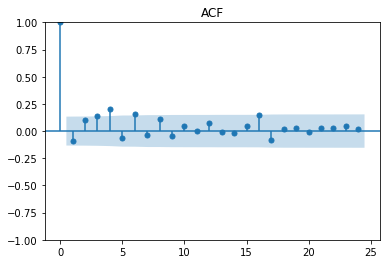

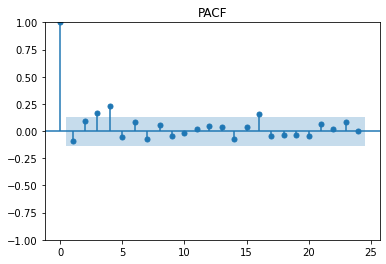

In [196]:
p = 1
d = 1
q = 0

arima_model = ARIMA(df_train['Adj Close'], order=(p,d,q)) # define model
model= arima_model.fit() # train model
print(model.summary()) 

residuals = model.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0],figsize=(15,3))
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

print(residuals.describe())

# Autocorrelation and partial correlation function of data
plot_acf(residuals)
plt.title("ACF")
plot_pacf(residuals)
plt.title("PACF")
plt.show()


As MA parameter was put at #, we have  trained coefficient for MA and one for AR. We can see scores such as AIC, BIC, and HQIC, as well as the std dev of innovations (difference of real value at time t and predicted value at the time). <br> <br> AIC can be used to test goodness of fit and shpuld be as low as possible as it measures the amount of information lost by training and generalising the model. <br> <br> There is a non-zero mean in the residuals indicating a bias in the prediction.

# Forecast 

<AxesSubplot:xlabel='Date'>

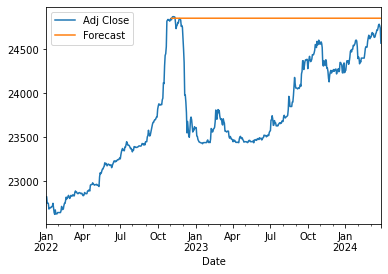

In [197]:
forecast_test = model.forecast(len(df_test))
df['Forecast'] = [None]*len(df_train) + list(forecast_test)

df_vis = df.copy()
df_vis.set_index("Date", inplace=True)
df_vis.drop(['diff1','growth_1','diff2','growth_2'], axis=1).plot()

# Evaluate model predictions

In [198]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test['Adj Close'], forecast_test)
mape = mean_absolute_percentage_error(df_test['Adj Close'], forecast_test)
rmse = np.sqrt(mean_squared_error(df_test['Adj Close'], forecast_test))

print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')

mae: 855.4332356121888
mape: 0.036042451284883564
rmse: 976.1948219111546
